# Single Soliton with Neural Network
## Contributor: Raonaqul Islam

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, ELU, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import random
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.activations import swish


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load data from google drive
#data = pd.read_csv('/content/drive/MyDrive/Documents/5. Fall 2024/CMSC 678/CMSC 678 Project/LLE/Dynamical (FSOLVE)/data/solitondata.csv')
data = pd.read_csv('solitondata.csv')

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
data

,alpha,beta,F,1,2,3,4,5,6,7,...,503,504,505,506,507,508,509,510,511,512
0,3.70,-0.15,2.48,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632,...,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632,0.754632
1,6.50,-0.10,3.26,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391,...,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391,0.516391
2,3.00,-0.15,2.70,1.087971,1.087972,1.087972,1.087973,1.087975,1.087976,1.087979,...,1.087991,1.087987,1.087984,1.087981,1.087979,1.087976,1.087975,1.087973,1.087972,1.087972
3,5.00,-0.05,4.55,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361,...,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361,1.330361
4,3.20,-0.15,2.68,1.112273,1.112273,1.112272,1.112270,1.112267,1.112263,1.112258,...,1.112229,1.112238,1.112245,1.112252,1.112258,1.112263,1.112267,1.112270,1.112272,1.112273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,8.00,-0.05,3.73,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913,...,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913,0.475913
4550,3.70,-0.15,2.43,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395,...,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395,0.732395
4551,6.00,-0.05,2.43,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721,...,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721,0.410721
4552,7.00,-0.05,3.21,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340,...,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340,0.468340


In [4]:
# Let us separate the input and target
X = data.iloc[:,:3] # First 3 columns are input features
y = data.iloc[:,3:] # Next 512 columns are targets

In [5]:
# Let us split the data into training (80%), validation (10%), and testing (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
def residual_block(x, units, kernel_regularizer=None, dropout_rate=None):
    """
    A residual block for a fully connected network.

    Args:
        x: Input tensor.
        units: Number of neurons in the dense layers.
        kernel_regularizer: Regularizer for the Dense layers (optional).
        dropout_rate: Dropout rate after the residual block (optional).

    Returns:
        Output tensor after applying the residual block.
    """
    shortcut = x  # Save the input for the skip connection

    # First transformation
    x = Dense(units, activation='relu', kernel_regularizer=kernel_regularizer)(x)

    # Second transformation (no activation here to allow residual addition)
    x = Dense(units, kernel_regularizer=kernel_regularizer)(x)

    # Adjust the shortcut's shape to match x if necessary
    # This is the crucial change to make the shapes compatible
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Dense(units, kernel_regularizer=kernel_regularizer)(shortcut)

    # Add the shortcut (skip connection)
    x = Add()([x, shortcut])

    # Optional: Add activation after combining the residual connection
    x = Dense(units, activation='relu', kernel_regularizer=kernel_regularizer)(x)

    # Optional: Add dropout if specified
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [7]:
# Define the Functional API Model
input_tensor = Input(shape=(3,))  # Input size is 3 for alpha, beta, F

# Initial Dense layer
x = Dense(128, activation='relu')(input_tensor)

# Add a residual block
x = residual_block(x, 256, kernel_regularizer=l2(1e-6))

# Add another residual block
x = residual_block(x, 256)

# Dropout layer
x = Dropout(0.1)(x)

# Add additional dense layers
x = Dense(512, activation='relu')(x)

# Final output layer
output_tensor = Dense(512, activation='linear')(x)

# Create the model
NN = Model(inputs=input_tensor, outputs=output_tensor)
NN.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary
NN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         33,024 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │         65,792 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │         33,024 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │         65,792 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │         65,792 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │         65,792 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 512)            │        131,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 512)            │        262,656 │ dense_8[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 789,760 (3.01 MB)

 Trainable params: 789,760 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Now it is time to define the neural network model
'''
model = Sequential([
    Dense(128, input_dim=3, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='linear')
])'''

"\nmodel = Sequential([\n    Dense(128, input_dim=3, activation='relu'),\n    BatchNormalization(),\n    Dense(256, activation='relu'),\n    Dropout(0.2),\n    Dense(512, activation='relu'),\n    BatchNormalization(),\n    Dense(512, activation='linear')\n])"

In [10]:
# model.summary()

In [11]:
# Compile the model
NN.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Let us add some rule so it stops when validation loss is low
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1) # This way the learning rate can change when validation loss is not low
history = NN.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks = [reduce_lr,early_stopping], epochs=50, batch_size=16, verbose=1)

Epoch 1/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1061 - mae: 0.2019 - val_loss: 0.0142 - val_mae: 0.0641 - learning_rate: 0.0010
Epoch 2/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0136 - mae: 0.0662 - val_loss: 0.0093 - val_mae: 0.0583 - learning_rate: 0.0010
Epoch 3/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0097 - mae: 0.0527 - val_loss: 0.0065 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 4/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0087 - mae: 0.0484 - val_loss: 0.0044 - val_mae: 0.0392 - learning_rate: 0.0010
Epoch 5/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0064 - mae: 0.0461 - val_loss: 0.0025 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 6/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - mae: 0.0421 - val_loss: 0.0097 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 7/50
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0038 - mae: 0.0329 - val_loss: 0.0021 - val_mae: 0.0249 - learning_rate: 0.0010

In [12]:
# Evaluate the model on test data
test_loss, test_mse = NN.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}, Test MSE: {test_mse}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4239e-04 - mae: 0.0056
Test Loss: 0.0005204277113080025, Test MSE: 0.005500332918018103


In [13]:
# Let us do some prediction
X_predict = np.array([4.0,-0.18,2.4])
X_predict = X_predict.reshape(1, -1)
y_predict = NN.predict(X_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


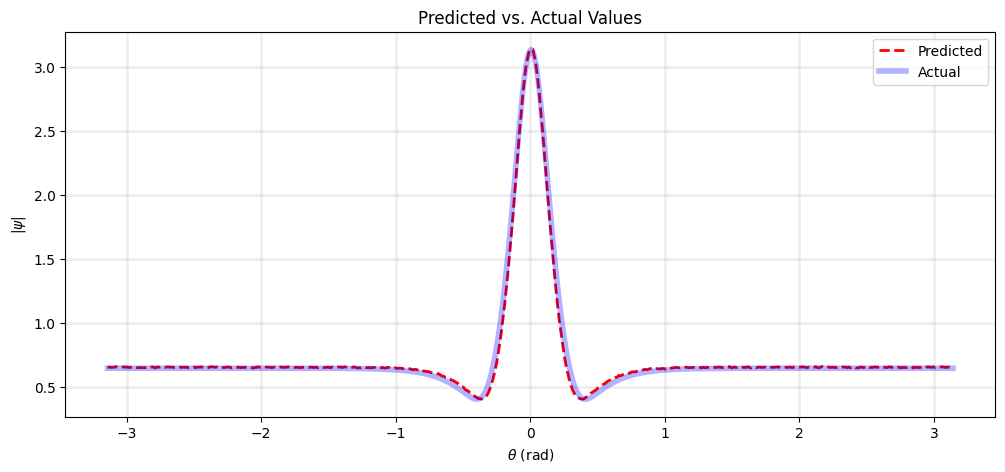

In [21]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,5))
xx = np.linspace(-np.pi,np.pi,512)
ax.plot(xx,y_predict[0],label='Predicted',c='r',ls='--',lw=2)
y_actual = [0.645013196,0.645013196,0.645013196,0.645013195,0.645013194,0.645013193,0.645013192,0.645013191,0.645013189,0.645013187,0.645013185,0.645013183,0.64501318,0.645013177,0.645013174,0.64501317,0.645013166,0.645013161,0.645013156,0.64501315,0.645013144,0.645013138,0.64501313,0.645013122,0.645013113,0.645013103,0.645013092,0.645013081,0.645013068,0.645013054,0.645013039,0.645013022,0.645013004,0.645012984,0.645012962,0.645012939,0.645012913,0.645012885,0.645012855,0.645012821,0.645012785,0.645012746,0.645012703,0.645012657,0.645012606,0.645012551,0.645012491,0.645012426,0.645012355,0.645012278,0.645012195,0.645012104,0.645012006,0.645011899,0.645011783,0.645011657,0.645011521,0.645011372,0.645011212,0.645011037,0.645010848,0.645010643,0.645010421,0.64501018,0.645009919,0.645009637,0.64500933,0.645008998,0.645008639,0.64500825,0.645007828,0.645007372,0.645006878,0.645006344,0.645005766,0.64500514,0.645004463,0.645003731,0.645002939,0.645002082,0.645001156,0.645000155,0.644999073,0.644997903,0.644996639,0.644995273,0.644993797,0.644992202,0.64499048,0.644988619,0.64498661,0.644984441,0.644982098,0.64497957,0.64497684,0.644973894,0.644970714,0.644967283,0.644963582,0.644959588,0.64495528,0.644950634,0.644945623,0.644940219,0.644934393,0.644928111,0.64492134,0.644914042,0.644906175,0.644897699,0.644888565,0.644878724,0.644868122,0.644856702,0.644844403,0.644831156,0.644816893,0.644801535,0.644785,0.644767201,0.644748043,0.644727424,0.644705235,0.644681359,0.64465567,0.644628035,0.644598308,0.644566334,0.644531948,0.644494972,0.644455214,0.64441247,0.644366521,0.644317131,0.644264048,0.644207003,0.644145707,0.644079849,0.644009097,0.643933098,0.643851469,0.643763804,0.643669667,0.64356859,0.643460074,0.643343585,0.64321855,0.643084358,0.642940353,0.642785836,0.642620056,0.642442215,0.642251455,0.64204686,0.641827454,0.64159219,0.64133995,0.641069541,0.640779688,0.640469028,0.640136107,0.639779371,0.639397161,0.638987707,0.638549119,0.638079379,0.637576336,0.637037694,0.636461003,0.635843653,0.635182857,0.634475648,0.633718859,0.63290912,0.632042838,0.631116185,0.630125086,0.629065203,0.627931918,0.626720318,0.625425179,0.624040946,0.622561714,0.620981215,0.61929279,0.617489376,0.615563485,0.613507183,0.611312072,0.608969272,0.606469405,0.603802578,0.600958376,0.597925853,0.59469353,0.591249405,0.587580966,0.583675225,0.57951876,0.575097792,0.570398278,0.565406045,0.560106978,0.554487256,0.548533679,0.542234084,0.535577899,0.528556858,0.521165926,0.513404508,0.505278001,0.496799805,0.487993906,0.478898201,0.469568733,0.460085072,0.450557049,0.441133064,0.432010035,0.423444871,0.415766808,0.409389226,0.404818396,0.402655385,0.403586535,0.408358675,0.417738589,0.432462187,0.453184939,0.480447135,0.514662987,0.556133402,0.605074123,0.661647889,0.725991399,0.798231989,0.878492636,0.966885831,1.063497481,1.168361778,1.281427547,1.40251634,1.531272568,1.667106502,1.809132025,1.95610268,2.10635181,2.257745226,2.407657533,2.552985142,2.690209178,2.815518635,2.924997429,3.014868299,3.081773213,3.123057236,3.137014721,3.123057236,3.081773213,3.014868299,2.924997429,2.815518635,2.690209178,2.552985142,2.407657533,2.257745226,2.10635181,1.95610268,1.809132025,1.667106502,1.531272568,1.40251634,1.281427547,1.168361778,1.063497481,0.966885831,0.878492636,0.798231989,0.725991399,0.661647889,0.605074123,0.556133402,0.514662987,0.480447135,0.453184939,0.432462187,0.417738589,0.408358675,0.403586535,0.402655385,0.404818396,0.409389226,0.415766808,0.423444871,0.432010035,0.441133064,0.450557049,0.460085072,0.469568733,0.478898201,0.487993906,0.496799805,0.505278001,0.513404508,0.521165926,0.528556858,0.535577899,0.542234084,0.548533679,0.554487256,0.560106978,0.565406045,0.570398278,0.575097792,0.57951876,0.583675225,0.587580966,0.591249405,0.59469353,0.597925853,0.600958376,0.603802578,0.606469405,0.608969272,0.611312072,0.613507183,0.615563485,0.617489376,0.61929279,0.620981215,0.622561714,0.624040946,0.625425179,0.626720318,0.627931918,0.629065203,0.630125086,0.631116185,0.632042838,0.63290912,0.633718859,0.634475648,0.635182857,0.635843653,0.636461003,0.637037694,0.637576336,0.638079379,0.638549119,0.638987707,0.639397161,0.639779371,0.640136107,0.640469028,0.640779688,0.641069541,0.64133995,0.64159219,0.641827454,0.64204686,0.642251455,0.642442215,0.642620056,0.642785836,0.642940353,0.643084358,0.64321855,0.643343585,0.643460074,0.64356859,0.643669667,0.643763804,0.643851469,0.643933098,0.644009097,0.644079849,0.644145707,0.644207003,0.644264048,0.644317131,0.644366521,0.64441247,0.644455214,0.644494972,0.644531948,0.644566334,0.644598308,0.644628035,0.64465567,0.644681359,0.644705235,0.644727424,0.644748043,0.644767201,0.644785,0.644801535,0.644816893,0.644831156,0.644844403,0.644856702,0.644868122,0.644878724,0.644888565,0.644897699,0.644906175,0.644914042,0.64492134,0.644928111,0.644934393,0.644940219,0.644945623,0.644950634,0.64495528,0.644959588,0.644963582,0.644967283,0.644970714,0.644973894,0.64497684,0.64497957,0.644982098,0.644984441,0.64498661,0.644988619,0.64499048,0.644992202,0.644993797,0.644995273,0.644996639,0.644997903,0.644999073,0.645000155,0.645001156,0.645002082,0.645002939,0.645003731,0.645004463,0.64500514,0.645005766,0.645006344,0.645006878,0.645007372,0.645007828,0.64500825,0.645008639,0.645008998,0.64500933,0.645009637,0.645009919,0.64501018,0.645010421,0.645010643,0.645010848,0.645011037,0.645011212,0.645011372,0.645011521,0.645011657,0.645011783,0.645011899,0.645012006,0.645012104,0.645012195,0.645012278,0.645012355,0.645012426,0.645012491,0.645012551,0.645012606,0.645012657,0.645012703,0.645012746,0.645012785,0.645012821,0.645012855,0.645012885,0.645012913,0.645012939,0.645012962,0.645012984,0.645013004,0.645013022,0.645013039,0.645013054,0.645013068,0.645013081,0.645013092,0.645013103,0.645013113,0.645013122,0.64501313,0.645013138,0.645013144,0.64501315,0.645013156,0.645013161,0.645013166,0.64501317,0.645013174,0.645013177,0.64501318,0.645013183,0.645013185,0.645013187,0.645013189,0.645013191,0.645013192,0.645013193,0.645013194,0.645013195,0.645013196,0.645013196];
ax.plot(xx,y_actual,label='Actual',ls='-',c='b',lw=4,alpha=0.3)
ax.legend()
ax.grid(alpha=0.2,lw=2)
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r"$|\psi|$")
ax.set_title("Predicted vs. Actual Values")
plt.savefig('soliton_NN_1.svg')
plt.savefig('soliton_NN_1.pdf')
plt.show()

In [ ]:
# Let us do some prediction
X_predict = np.array([10.0,-0.02,3]) # alpha,beta,F
X_predict = X_predict.reshape(1, -1)
y_predict = NN.predict(X_predict) # Remove the extra brackets around X_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


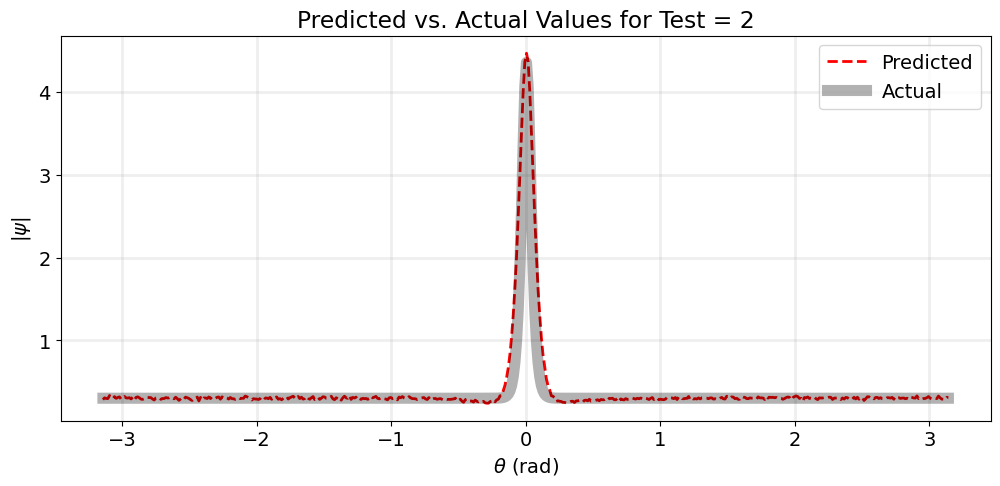

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,5))
xx = np.linspace(-np.pi,np.pi,512)
ax.plot(xx,y_predict[0],label='Predicted',c='r',ls='--',lw=2)
y_actual = [0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205025,0.301228914,0.301205025,0.301228914,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205028,0.30122891,0.301205028,0.30122891,0.301205028,0.30122891,0.301205028,0.30122891,0.301205029,0.301228909,0.301205029,0.301228909,0.301205029,0.301228908,0.301205029,0.301228908,0.301205029,0.301228907,0.301205029,0.301228905,0.301205028,0.301228902,0.301205025,0.301228897,0.301205019,0.301228886,0.301205006,0.301228866,0.30120498,0.301228827,0.301204927,0.301228751,0.301204823,0.301228604,0.301204621,0.301228321,0.301204235,0.301227788,0.301203511,0.301226805,0.301202192,0.301225045,0.301199876,0.301222035,0.301196034,0.301217252,0.301190264,0.301210658,0.30118331,0.301204562,0.301180333,0.301209262,0.301200486,0.301259199,0.301303979,0.301458448,0.301668803,0.302111496,0.302816283,0.304118913,0.306316447,0.310254936,0.317122692,0.329421938,0.351141575,0.389384163,0.454635611,0.562250868,0.73200102,0.989866485,1.367028767,1.895788383,2.587174909,3.380451162,4.074052262,4.360459052,4.074052262,3.380451162,2.587174909,1.895788383,1.367028767,0.989866485,0.73200102,0.562250868,0.454635611,0.389384163,0.351141575,0.329421938,0.317122692,0.310254936,0.306316447,0.304118913,0.302816283,0.302111496,0.301668803,0.301458448,0.301303979,0.301259199,0.301200486,0.301209262,0.301180333,0.301204562,0.30118331,0.301210658,0.301190264,0.301217252,0.301196034,0.301222035,0.301199876,0.301225045,0.301202192,0.301226805,0.301203511,0.301227788,0.301204235,0.301228321,0.301204621,0.301228604,0.301204823,0.301228751,0.301204927,0.301228827,0.30120498,0.301228866,0.301205006,0.301228886,0.301205019,0.301228897,0.301205025,0.301228902,0.301205028,0.301228905,0.301205029,0.301228907,0.301205029,0.301228908,0.301205029,0.301228908,0.301205029,0.301228909,0.301205029,0.301228909,0.301205029,0.30122891,0.301205028,0.30122891,0.301205028,0.30122891,0.301205028,0.30122891,0.301205028,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228911,0.301205027,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228912,0.301205026,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228913,0.301205025,0.301228914,0.301205025,0.301228914,0.301205025,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024,0.301228914,0.301205024];
ax.plot(xx,y_actual,label='Actual',ls='-',c='k',lw=8,alpha=0.3)
ax.legend()
ax.grid(alpha=0.2,lw=2)
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r"$|\psi|$")
ax.set_title("Predicted vs. Actual Values for Test = 2")
plt.savefig('soliton_NN_2.svg')
plt.savefig('soliton_NN_2.pdf')
plt.show()

In [ ]:
# Here we select the first sample from the test set for comparison
X_predict = X_test.iloc[256].values
y_predict = NN.predict(X_predict.reshape(1, -1))  # Reshape and predict
y_actual = y_test.iloc[256].values      # Actual values for the selected sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


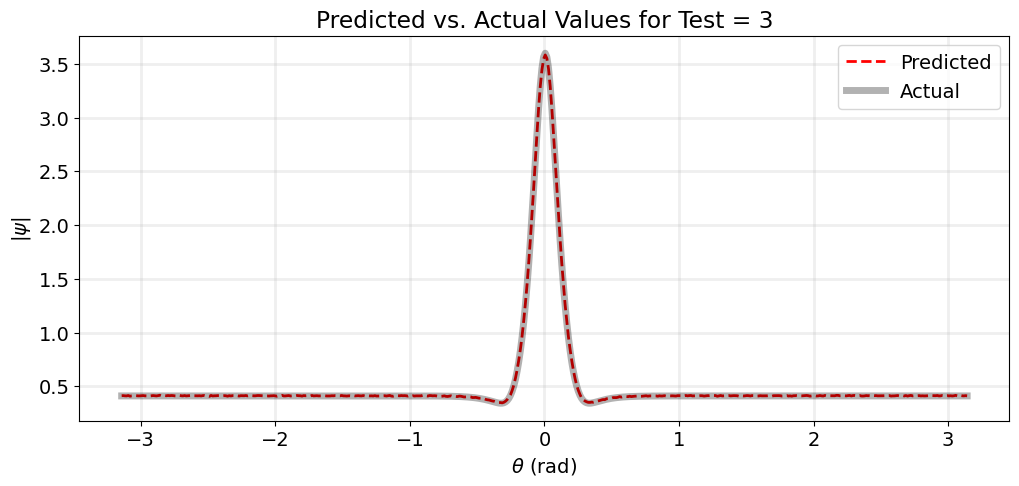

In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(12,5))
xx = np.linspace(-np.pi,np.pi,512)  # X-axis range for the 512 points in each sample
plt.rcParams["font.size"] = 14
ax.plot(xx, y_predict[0], label='Predicted',c='r',ls='--',lw=2)
ax.plot(xx, y_actual, label='Actual',ls='-',c='k',lw=5,alpha=0.3)  # Dashed line for actual values
ax.legend()
ax.grid(alpha=0.2,lw=2)
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r"$|\psi|$")
ax.set_title("Predicted vs. Actual Values for Test = 3")
plt.savefig('soliton_NN_3.svg')
plt.savefig('soliton_NN_3.pdf')
plt.show()


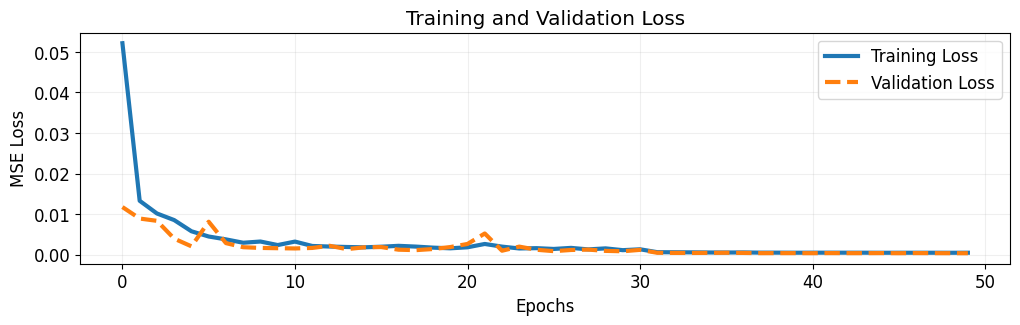

In [ ]:
# Let us take a look how the training history looks like
fig,ax = plt.subplots(figsize=(12,3))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
ax.plot(history.history['loss'], label='Training Loss',lw=3)
ax.plot(history.history['val_loss'], label='Validation Loss',lw=3,ls='--')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(alpha=0.2)
plt.savefig('soliton_NN_loss.svg')
plt.show()